# BAX Emittance Minimization (LCLS-II)
In this notebook, we hope to demonstrate Bayesian Algorithm Execution (BAX) in Xopt as a means of minimizing the emittance at LCLS-II. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

In [1]:
# set up env for running on SLAC production servers
import os
os.environ['OMP_NUM_THREADS']=str(6)

In [2]:
run_dir = '/home/physics/ml_tuning/20240225_LCLS_II_Injector'

# Read pv info from YAML files

In [3]:
import sys
import yaml
sys.path.append("../../")
sys.path.append("../../../")

from common import get_pv_objects, save_reference_point, set_magnet_strengths, \
    measure_pvs

In [4]:
pv_bounds = yaml.safe_load(open("../../pv_bounds.yml"))
pv_objects = get_pv_objects("../../tracked_pvs.yml")

In [5]:
pv_bounds

{'QUAD:GUNB:212:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:212:2:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:2:BCTRL': [-0.005, 0.005],
 'QUAD:HTR:120:BCTRL': [-4, 0],
 'QUAD:HTR:140:BCTRL': [-4.4778, 4.4762],
 'QUAD:HTR:300:BCTRL': [-4.46035, 4.4692],
 'QUAD:HTR:320:BCTRL': [-4.46919, 4.4792],
 'SOLN:GUNB:212:BCTRL': [0.044, 0.044574],
 'SOLN:GUNB:823:BCTRL': [0.021, 0.0255]}

# load reference point
Also define a function to write the reference values to the pvs

In [6]:
reference = yaml.safe_load(open("../../reference.yml"))

def reset_pvs():
    set_magnet_strengths(reference, pv_objects, validate=False)

In [7]:
reset_pvs()

QUAD:GUNB:212:1:BCTRL 0.0019979999999999998
QUAD:GUNB:212:2:BCTRL 0.0024625
QUAD:GUNB:823:1:BCTRL 0.0029849192
QUAD:GUNB:823:2:BCTRL 0.0020575000000000003
QUAD:HTR:120:BCTRL -2.335956937533228
QUAD:HTR:140:BCTRL 1.6975759721701786
QUAD:HTR:300:BCTRL 1.717953462815712
QUAD:HTR:320:BCTRL -1.7056625208016953
SOLN:GUNB:212:BCTRL 0.044250000000000005
SOLN:GUNB:823:BCTRL 0.024170000000000014


In [8]:
from scripts.image import ImageDiagnostic
import yaml

fname = 'otr_diagnostic.yml' #run_dir + "OTRS_HTR_330_config.yml"

image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))

image_diagnostic.min_log_intensity = 3.0
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
print(image_diagnostic.yaml())


screen_name: OTRS:HTR:330
array_data_suffix: Image:ArrayData
array_n_cols_suffix: Image:ArraySize0_RBV
array_n_rows_suffix: Image:ArraySize1_RBV
resolution_suffix: RESOLUTION
resolution: 19.24
beam_shutter_pv: TPR:LGUN:TS01:0:TRG00_SYS2_TCTL
extra_pvs: []
background_file: null
save_image_location: /home/physics/ml_tuning/20240225_LCLS_II_Injector
roi: null
min_log_intensity: 3.0
bounding_box_half_width: 3.0
wait_time: 1.0
n_fitting_restarts: 2
visualize: false
return_statistics: false
threshold: 0.0
testing: false



In [9]:
image_diagnostic.measure_background()

array([[0.2, 0. , 0.2, ..., 0.6, 0.6, 0.4],
       [0.2, 0.2, 0. , ..., 0. , 0.4, 0.4],
       [0.4, 0.4, 0.6, ..., 0.2, 0.2, 0.2],
       ...,
       [0.4, 0.2, 0.2, ..., 0.8, 0. , 0.2],
       [0. , 0. , 0.2, ..., 0.4, 0.2, 0.2],
       [1.8, 0.4, 0. , ..., 0. , 0.2, 0.2]])

In [10]:
import matplotlib.pyplot as plt

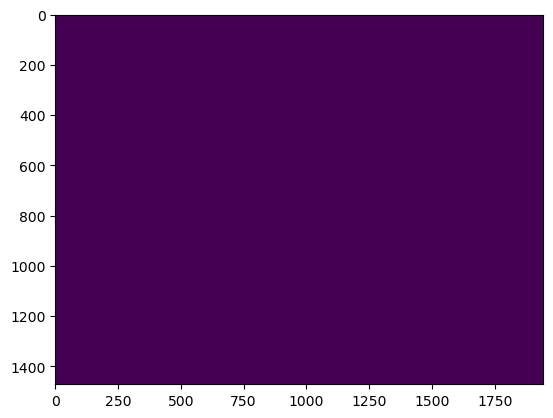

In [11]:
plt.imshow(image_diagnostic.background_image)

In [12]:
image_diagnostic.resolution

19.24

In [14]:
from epics import caget

In [16]:
caget('OTRS:HTR:330:RESOLUTION')

19.24

fitting image


{'Cx': 1058.4439537308397,
 'Cy': 953.1602144331546,
 'Sx': 244.24046158298157,
 'Sy': 317.5757721755835,
 'bb_penalty': -369.0495324709556,
 'total_intensity': 735496.6000000003,
 'log10_total_intensity': 5.866580669443357}

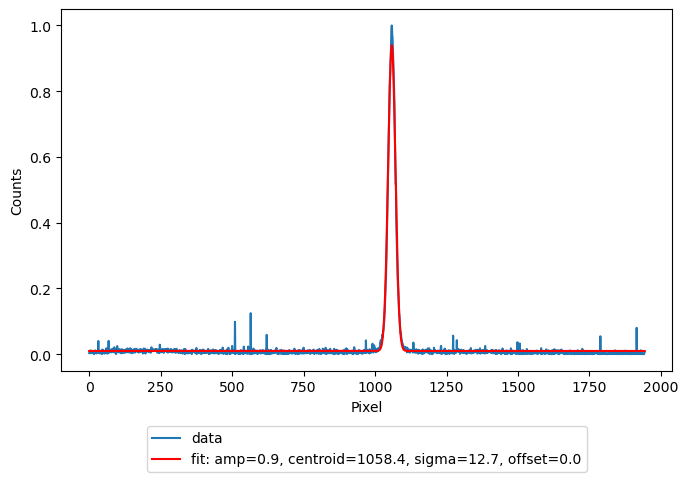

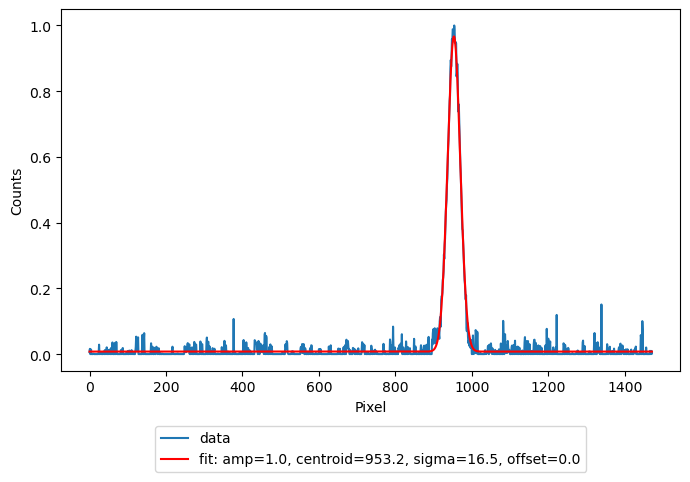

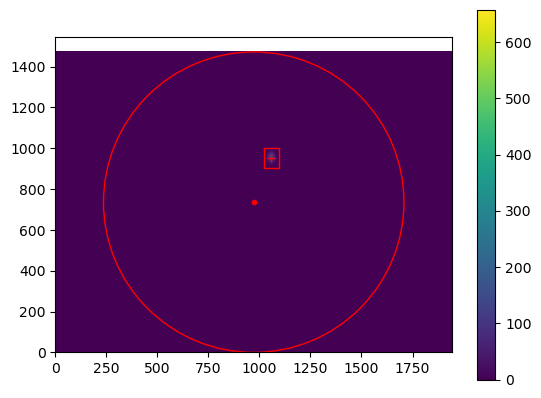

In [13]:
image_diagnostic.test_measurement()

# Imports

In [9]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator


import time
import numpy as np
import random

# General settings

In [10]:
# general settings
N_OBS_INIT = 3 # number of random initial observations
N_ITER = 20 # number of iterations for Xopt to perform

# BAX algorithm settings
N_SAMPLES = 10
N_STEPS_MEASUREMENT_PARAM = 3

# measurement settings
VAR_FILE = '../variables.csv'
TUNING_VARIABLES = ["SOLN:GUNB:212:BCTRL", 'QUAD:HTR:120:BCTRL']
SCAN_VARIABLE = "QUAD:HTR:120:BCTRL" # assign measurement parameter
SCREEN_NAME = "OTRS:HTR:330"
X_KEY = "xrms_sq"
Y_KEY = "yrms_sq"
QUAD_LENGTH = 0.124 # m
RMAT_X =  [[-1.4591, 2.9814],
[-0.4998, 0.3358]] # m
RMAT_Y = [[4.8650, 8.5737],
[-0.1597, -0.0758]]
THICK_QUAD = False
BEAM_ENERGY = 0.088 # GeV
SCALE_FACTOR = 2.74 # multiplicative factor to convert from measurement quad PV units to geometric focusing strength
ROI = None
THRESHOLD = 0

# random seeds for reproducibility
rand_seed = 2
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) # only(?) affects initial random observations through Xopt 
random.seed(rand_seed)

# Evaluator

In [11]:
import time
# define function to measure the total size on OTR4
def eval_beamsize(inputs):
    
    # set pvs and wait for BACT to settle to correct values (validate=True)
    set_magnet_strengths(inputs, pv_objects, validate=False)
    time.sleep(2)
    # measure all pvs - except for names in inputs
    results = measure_pvs(
        [name for name in pv_objects.keys() if name not in inputs], pv_objects 
    )

    # do some calculations
    results["time"] = time.time()

    # add beam size measurement to results dict
    beamsize_results = image_diagnostic.measure_beamsize()
    results["Sx_mm"] = beamsize_results["Sx"] * 1e-3
    results["Sy_mm"] = beamsize_results["Sy"] * 1e-3

    #add beam size squared (mm^2)
    results["xrms_sq"] = results["Sx_mm"]**2
    results["yrms_sq"] = results["Sy_mm"]**2
    results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
    results = beamsize_results | results
    return results

In [13]:
eval_beamsize({})

fitting image


{'Cx': 1058.2503668898055,
 'Cy': 968.941869599713,
 'Sx': 245.81733477254633,
 'Sy': 271.3508993225007,
 'bb_penalty': -372.57756970446263,
 'total_intensity': 1153870.0,
 'log10_total_intensity': 6.062156882075392,
 'save_filename': '/home/physics/ml_tuning/20240225_LCLS_II_Injector/OTRS_HTR_330_1708925598.h5',
 'QUAD:HTR:140:BCTRL': 1.6975759721701786,
 'QUAD:HTR:300:BCTRL': 1.717953462815712,
 'QUAD:HTR:320:BCTRL': -1.7056625208016953,
 'SOLN:GUNB:212:BCTRL': 0.044250000000000005,
 'QUAD:GUNB:212:1:BCTRL': 0.0019979999999999998,
 'QUAD:GUNB:212:2:BCTRL': 0.0024625,
 'SOLN:GUNB:823:BCTRL': 0.024170000000000014,
 'QUAD:GUNB:823:1:BCTRL': 0.0029849192,
 'QUAD:GUNB:823:2:BCTRL': 0.0020575000000000003,
 'ACCL:GUNB:455:PDES': -132.5,
 'ACCL:L0B:0110:ADES': 6.5,
 'ACCL:L0B:0110:PDES': -20.0,
 'ACCL:L0B:0130:PDES': 0.0,
 'QUAD:HTR:120:BCTRL': -2.335956937533228,
 'time': 1708925598.6954544,
 'Sx_mm': 0.24581733477254633,
 'Sy_mm': 0.2713508993225007,
 'xrms_sq': 0.060426162074678116,
 'yrm

## Constants and Constraints

In [14]:
# constants



# constraints
image_constraints = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", 4]
}

# VOCS

In [15]:
# construct vocs
vocs = VOCS(
    variables = {ele: pv_bounds[ele] for ele in TUNING_VARIABLES},
    constraints = image_constraints,
    objectives = {'total_beam_size': 'MINIMIZE'},
)

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
# get dimension index for measurement device
MEAS_DIM = list(vocs.variable_names).index(SCAN_VARIABLE)
print('MEAS_DIM =', MEAS_DIM)

MEAS_DIM = 0


# Numerical optimizer (for acquisition function)

In [20]:
from xopt.numerical_optimizer import LBFGSOptimizer, Upp
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
numerical_optimizer = LBFGSOptimizer(n_restarts=20,
                                    max_iter=100)

# Initialize Xopt Optimizer

In [21]:
#construct BAX generator
generator = UpperConfidenceBoundGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                        n_interpolate_points=5)
#construct evaluator
evaluator = Evaluator(function=eval_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [22]:
optimizer.dump_file = 'BAX_run7.yml'

In [35]:
from epics import caget, caput

In [36]:
caget('QUAD:HTR:120:BCTRL')

-2.335956937533228

In [46]:
caput('QUAD:HTR:120:BCTRL', -2.335956937533228)

1

In [47]:
caget('SOLN:GUNB:212:BCTRL')

0.044250000000000005

In [51]:
caput('SOLN:GUNB:212:BCTRL', 0.044250000000000005)

1

In [23]:
results = {}

In [24]:
from epics import caget_many
from xopt.utils import get_local_region
# get current point
current_value = dict(zip(optimizer.vocs.variable_names, caget_many(optimizer.vocs.variable_names)))
# get small region around current point to sample
random_sample_region = get_local_region(current_value,optimizer.vocs, fraction=1)
# random sample in a local region
optimizer.random_evaluate(10, custom_bounds=random_sample_region)

QUAD:HTR:120:BCTRL -1.743979608568015
SOLN:GUNB:212:BCTRL 0.04421746917999042
fitting image
QUAD:HTR:120:BCTRL -0.10370492731156533
SOLN:GUNB:212:BCTRL 0.04427027243788498
fitting image
QUAD:HTR:120:BCTRL -2.1986499115148366
SOLN:GUNB:212:BCTRL 0.04449675111137201
fitting image
QUAD:HTR:120:BCTRL -1.7412895704731075
SOLN:GUNB:212:BCTRL 0.044279206158393467
fitting image
QUAD:HTR:120:BCTRL -1.6814712083499561
SOLN:GUNB:212:BCTRL 0.044468131517118675
fitting image
QUAD:HTR:120:BCTRL -1.3213392840154965
SOLN:GUNB:212:BCTRL 0.04412321762515323
fitting image
QUAD:HTR:120:BCTRL -0.81859453615137
SOLN:GUNB:212:BCTRL 0.044083818182024934
fitting image
QUAD:HTR:120:BCTRL -2.477083865402655
SOLN:GUNB:212:BCTRL 0.04429030805534277
fitting image
QUAD:HTR:120:BCTRL -1.1986186946980926
SOLN:GUNB:212:BCTRL 0.044088073707404814
fitting image
QUAD:HTR:120:BCTRL -1.0673091004114665
SOLN:GUNB:212:BCTRL 0.04452828349619681
fitting image


,QUAD:HTR:120:BCTRL,SOLN:GUNB:212:BCTRL,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,...,ACCL:L0B:0110:ADES,ACCL:L0B:0110:PDES,ACCL:L0B:0130:PDES,time,Sx_mm,Sy_mm,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-1.743980,0.044217,1073.431726,898.390014,208.431273,543.639112,-333.591603,1171365.0,6.068692,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.208431,0.543639,0.043444,0.295543,3.421134,False
1,-0.103705,0.044270,1115.448734,677.585837,253.830029,1291.687909,-86.829699,1215795.0,6.084860,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.253830,1.291688,0.064430,1.668458,3.397653,False
2,-2.198650,0.044497,1079.366303,867.627278,214.221694,751.515551,-298.918248,1179521.0,6.071706,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.214222,0.751516,0.045891,0.564776,3.421773,False
3,-1.741290,0.044279,1073.702925,890.258853,207.244709,604.407303,-326.264488,1184945.0,6.073698,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.207245,0.604407,0.042950,0.365308,3.530912,False
4,-1.681471,0.044468,1075.749556,885.096260,207.423911,651.875377,-318.863643,1166973.0,6.067061,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.207424,0.651875,0.043025,0.424942,3.466582,False
5,-1.321339,0.044123,1085.410939,832.294419,202.537513,885.001069,-264.543064,1188159.0,6.074875,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.202538,0.885001,0.041021,0.783227,3.462682,False
6,-0.818595,0.044084,1097.972794,745.927986,217.092792,443.692752,-242.186972,1208633.0,6.082294,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.217093,0.443693,0.047129,0.196863,3.482973,False
7,-2.477084,0.044290,1058.671119,952.117038,232.978958,353.766878,-369.241946,1174815.0,6.069969,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.232979,0.353767,0.054279,0.125151,3.434920,False
8,-1.198619,0.044088,1088.467305,814.233490,202.327568,900.394922,-249.823549,1183088.0,6.073017,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.202328,0.900395,0.040936,0.810711,3.424577,False
9,-1.067309,0.044528,1092.990857,795.179944,228.200048,1063.849810,-214.888182,1193323.0,6.076758,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708926e+09,0.228200,1.063850,0.052075,1.131776,3.558857,False


# Optimize

In [25]:
for i in range(1, N_ITER+1):

    print('Iteration:', i, '/', N_ITER)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    # model = optimizer.generator.train_model()
    # bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
    #                         for name in optimizer.generator.algorithm.observable_names_ordered]
    # bax_model = model.subset_output(bax_model_ids)
    # beam_size_model_x = bax_model.models[0]
    # beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results[i] = optimizer.generator.algorithm_results

    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm

    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

Iteration: 1 / 20
QUAD:HTR:120:BCTRL -1.6528183635620608
SOLN:GUNB:212:BCTRL 0.044423192774031756
fitting image
QUAD:HTR:120:BCTRL -2.238327626712655
SOLN:GUNB:212:BCTRL 0.044318102051866703
fitting image
QUAD:HTR:120:BCTRL -2.8238368898632493
SOLN:GUNB:212:BCTRL 0.04421301132970165
fitting image
QUAD:HTR:120:BCTRL -3.409346153013843
SOLN:GUNB:212:BCTRL 0.0441079206075366
fitting image
QUAD:HTR:120:BCTRL -3.9948554161644374
SOLN:GUNB:212:BCTRL 0.04400282988537155
fitting image
This iteration took: 20.52802038192749 seconds.

Iteration: 2 / 20
QUAD:HTR:120:BCTRL -3.99588433293155
SOLN:GUNB:212:BCTRL 0.04405101086904128
fitting image
QUAD:HTR:120:BCTRL -3.9969132496986624
SOLN:GUNB:212:BCTRL 0.04409919185271101
fitting image
QUAD:HTR:120:BCTRL -3.997942166465775
SOLN:GUNB:212:BCTRL 0.04414737283638073
fitting image
QUAD:HTR:120:BCTRL -3.9989710832328873
SOLN:GUNB:212:BCTRL 0.044195553820050464
fitting image
QUAD:HTR:120:BCTRL -4.0
SOLN:GUNB:212:BCTRL 0.044243734803720194
fitting image
Th

<Axes: >

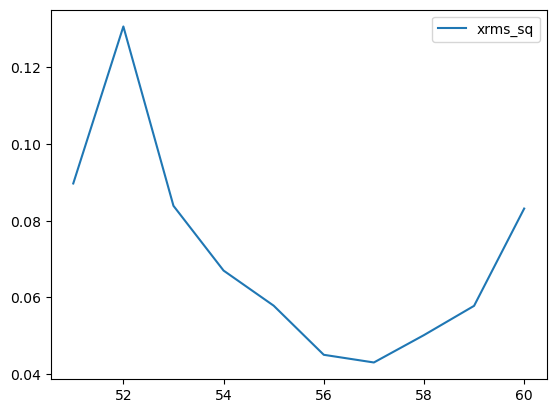

In [32]:
optimizer.data.iloc[-10:].plot(y='xrms_sq')

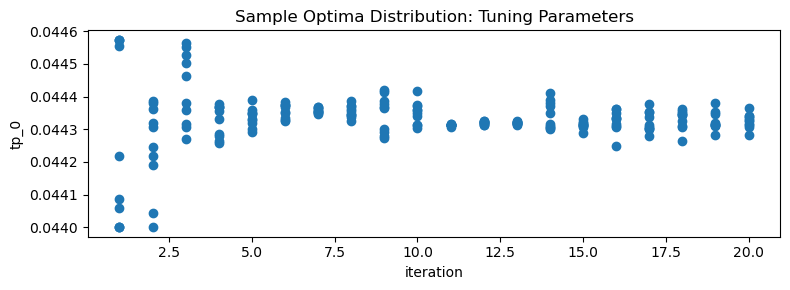

In [26]:
from emitopt.plot_utils import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(results, show_valid_only=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


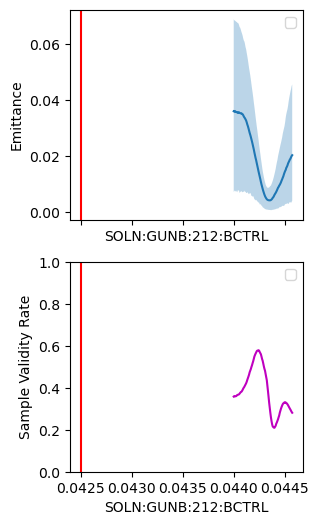

In [27]:
from plot_utils_fix import plot_virtual_emittance_vs_tuning
fig, axs = plot_virtual_emittance_vs_tuning(optimizer, torch.tensor([[0.0425]]))

(<Figure size 800x1600 with 20 Axes>,
 array([[<Axes: title={'center': 'Posterior Mean [bb_penalty]'}, ylabel='SOLN:GUNB:212:BCTRL'>,
         <Axes: title={'center': 'Posterior SD [bb_penalty]'}>],
        [<Axes: title={'center': 'Posterior Mean [log10_total_intensity]'}, ylabel='SOLN:GUNB:212:BCTRL'>,
         <Axes: title={'center': 'Posterior SD [log10_total_intensity]'}>],
        [<Axes: title={'center': 'Posterior Mean [xrms_sq]'}, ylabel='SOLN:GUNB:212:BCTRL'>,
         <Axes: title={'center': 'Posterior SD [xrms_sq]'}>],
        [<Axes: title={'center': 'Posterior Mean [yrms_sq]'}, ylabel='SOLN:GUNB:212:BCTRL'>,
         <Axes: title={'center': 'Posterior SD [yrms_sq]'}>],
        [<Axes: title={'center': 'Base Acq. Function'}, xlabel='QUAD:HTR:120:BCTRL', ylabel='SOLN:GUNB:212:BCTRL'>,
         <Axes: title={'center': 'Constrained Acq. Function'}, xlabel='QUAD:HTR:120:BCTRL'>]],
       dtype=object))

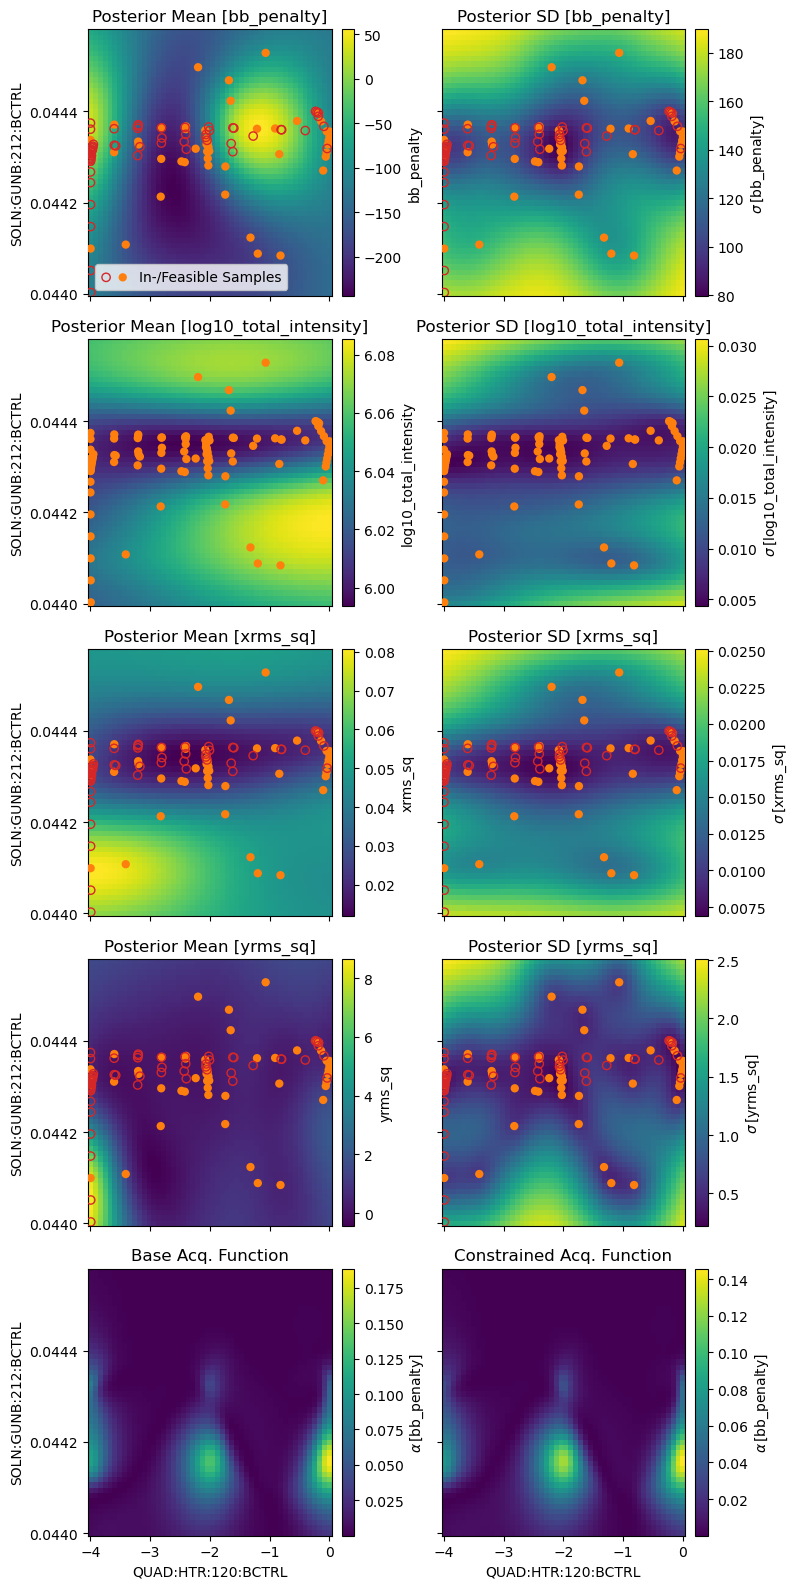

In [28]:
from xopt.generators.bayesian.visualize import visualize_generator_model
visualize_generator_model(optimizer.generator)

(<Figure size 600x1000 with 5 Axes>,
 array([<Axes: ylabel='bb_penalty'>,
        <Axes: ylabel='log10_total_intensity'>, <Axes: ylabel='xrms_sq'>,
        <Axes: ylabel='yrms_sq'>,
        <Axes: xlabel='QUAD:HTR:120:BCTRL', ylabel='$\\alpha\\,$[bb_penalty]'>],
       dtype=object))

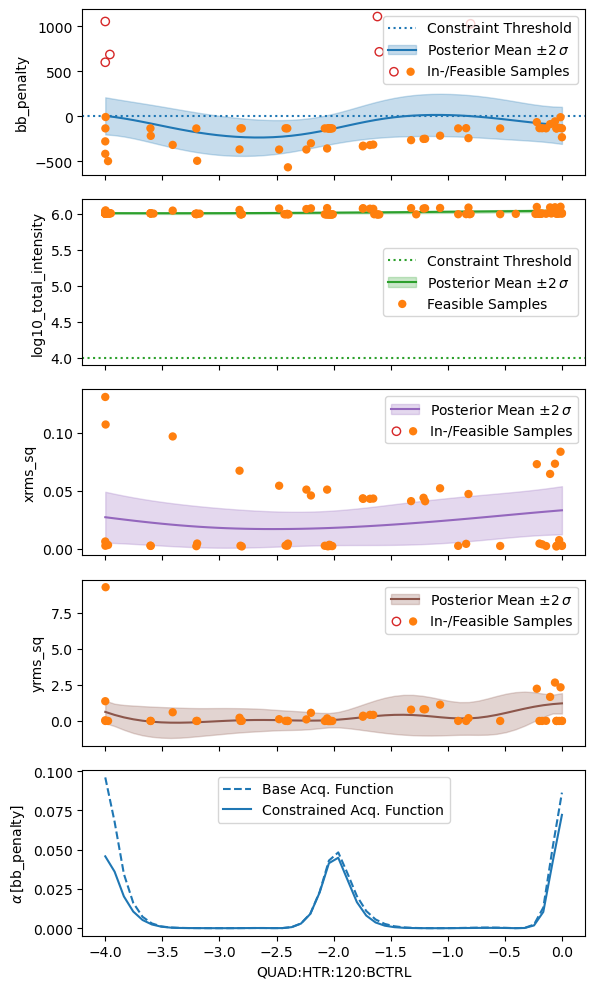

In [29]:
visualize_generator_model(optimizer.generator, variable_names=['QUAD:HTR:120:BCTRL'], 
                          reference_point={'SOLN:GUNB:212:BCTRL':0.0443})

<Axes: >

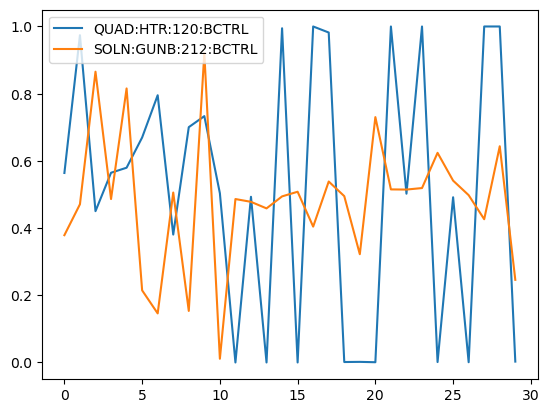

In [33]:
# you can also normalize the variables
optimizer.vocs.normalize_inputs(optimizer.data).plot(y=optimizer.vocs.variable_names)

In [ ]:
optimizer.dump_file = 'BAX_run1.yml'

In [30]:
data2 = optimizer.data[optimizer.data['xrms_sq']>0.025 and optimizer.data['yrms_sq']> ]


In [32]:
model = optimizer.generator.train_model(data2)

(<Figure size 600x1000 with 5 Axes>,
 array([<Axes: ylabel='bb_penalty'>,
        <Axes: ylabel='log10_total_intensity'>, <Axes: ylabel='xrms_sq'>,
        <Axes: ylabel='yrms_sq'>,
        <Axes: xlabel='QUAD:HTR:120:BCTRL', ylabel='$\\alpha\\,$[bb_penalty]'>],
       dtype=object))

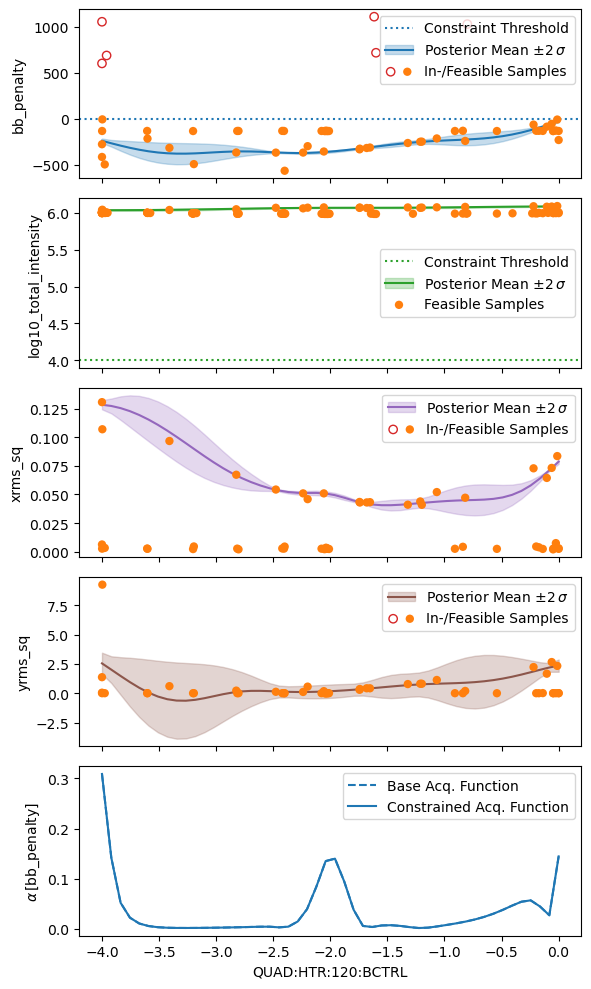

In [33]:
visualize_generator_model(optimizer.generator, variable_names=['QUAD:HTR:120:BCTRL'], 
                          reference_point={'SOLN:GUNB:212:BCTRL':0.0443})